# Draw Networks for positive genes in RNA-seq data

## 1. Identification of positive genes (from 解析フォーマット)

In [1]:
# import data frame
e <- read.csv("E.csv",as.is=T,row=1)
group<-c(rep("group1",3),rep("group2",3))
names(group)<-colnames(e)
Group1 = "CTR"
Group2 = "KD"
group<-sort(group)
e<-e[,names(group)]

# import libraries
require(DT)
require(edgeR)

# remove genes with low expression
data <- e
obj <- as.logical(rowSums(data) > 0)
data <- unique(data[obj,])
data_jokyo <- data

#DEG
param_G1 <- sum(group=="group1")
param_G2 <- sum(group=="group2")
param_FDR <- 0.05
data <- data_jokyo
data.cl <- c(rep(1, param_G1), rep(2, param_G2))
d <- DGEList(counts=data,group=data.cl)
d <- calcNormFactors(d)
norm.factors <- d$samples$norm.factors/mean(d$samples$norm.factors)
ef.libsizes <- colSums(data)*norm.factors
normalized.count <- sweep(data, 2, mean(ef.libsizes)/ef.libsizes, "*")
d <- estimateCommonDisp(d) 
d <- estimateTagwiseDisp(d)
out <- exactTest(d)
p.value <- out$table$PValue
q.value <- p.adjust(p.value, method="BH")
logFC <- out$table$logFC
FC <- 2^logFC
ranking <- rank(p.value)
tmp <- cbind(rownames(data), normalized.count, p.value, q.value,logFC,FC,ranking)
upDEG <- rownames(tmp[which((tmp$p.value < param_FDR) & (tmp$FC > 1)),])
downDEG <- rownames(tmp[which((tmp$p.value < param_FDR) & (tmp$FC < 1)),])

Loading required package: DT

Loading required package: edgeR

Loading required package: limma



## 2. Visualization of functional enrichment  (for upDEG)

### 2-1. import libraries

In [2]:
library(clusterProfiler)
library(enrichplot)
library(biomaRt)
library(DOSE)
library(org.Mm.eg.db)
library(org.Hs.eg.db)



Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

Warning message:
“package ‘biomaRt’ was built under R version 3.6.3”
DOSE v3.12.0  For help: https://guangchuangyu.github.io/software/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching p

### 2-2. convert gene symbol to entrez id

In [3]:
db <- useMart("ENSEMBL_MART_ENSEMBL")
HSapiens <- useDataset("hsapiens_gene_ensembl", mart = db)
SymbolToEntrez <- getBM(
    attributes = c("uniprot_gn_symbol", "entrezgene_id"),
    filters = "uniprot_gn_symbol",
    values = upDEG,
    mart = HSapiens
)
entrezList <- as.character(na.omit(SymbolToEntrez)[,2])

Cache found



### 2-3. KEGG pathway

### 2-3-1. barplot

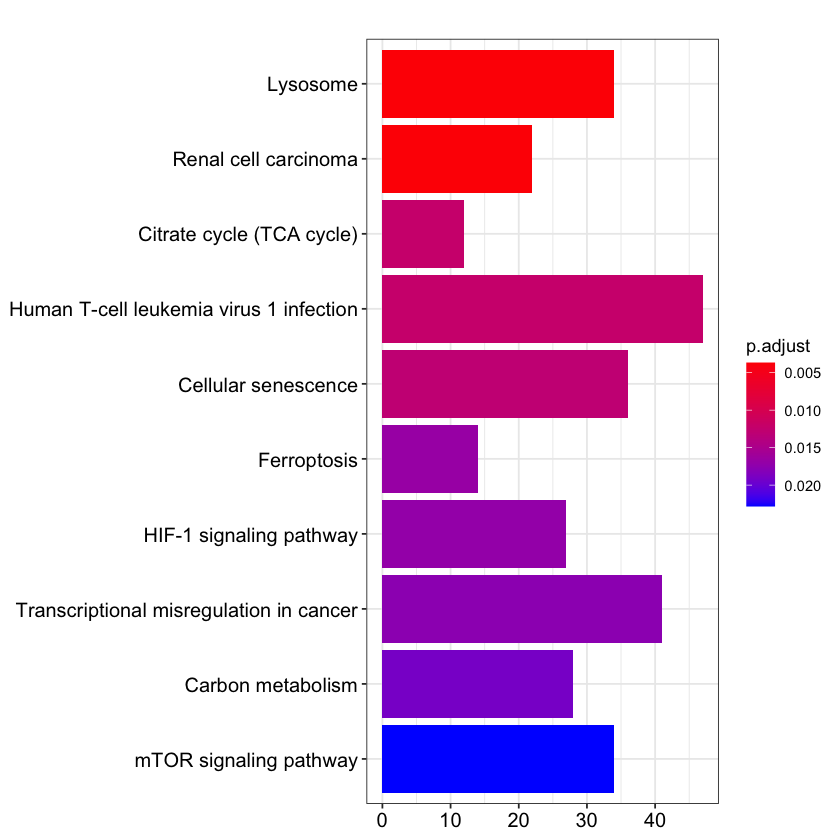

In [4]:
resKEGG <- enrichKEGG(entrezList, organism = "hsa")
barplot(resKEGG, showCategory = 10)

### 2-3-2. dotplot

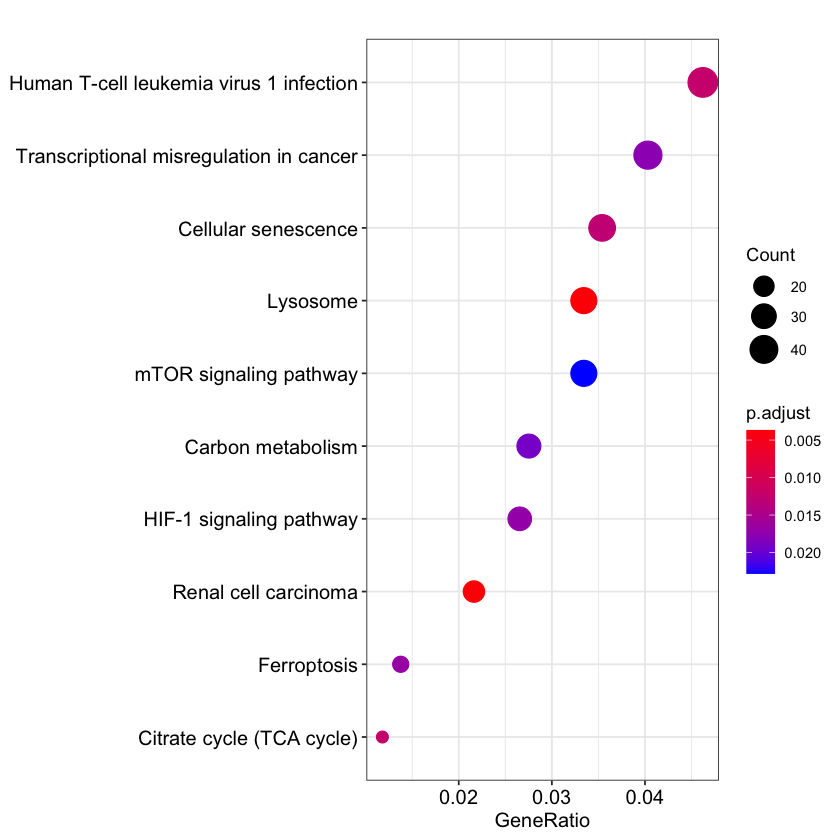

In [5]:
dotplot(resKEGG, showCategory = 10)

### 2-3-3. gene-concept network 

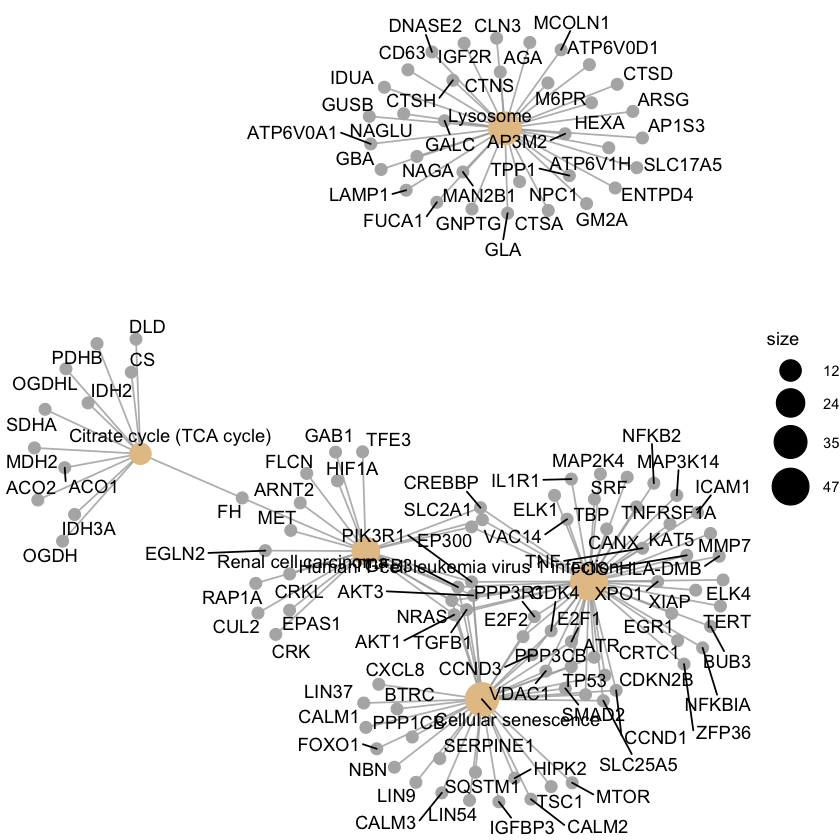

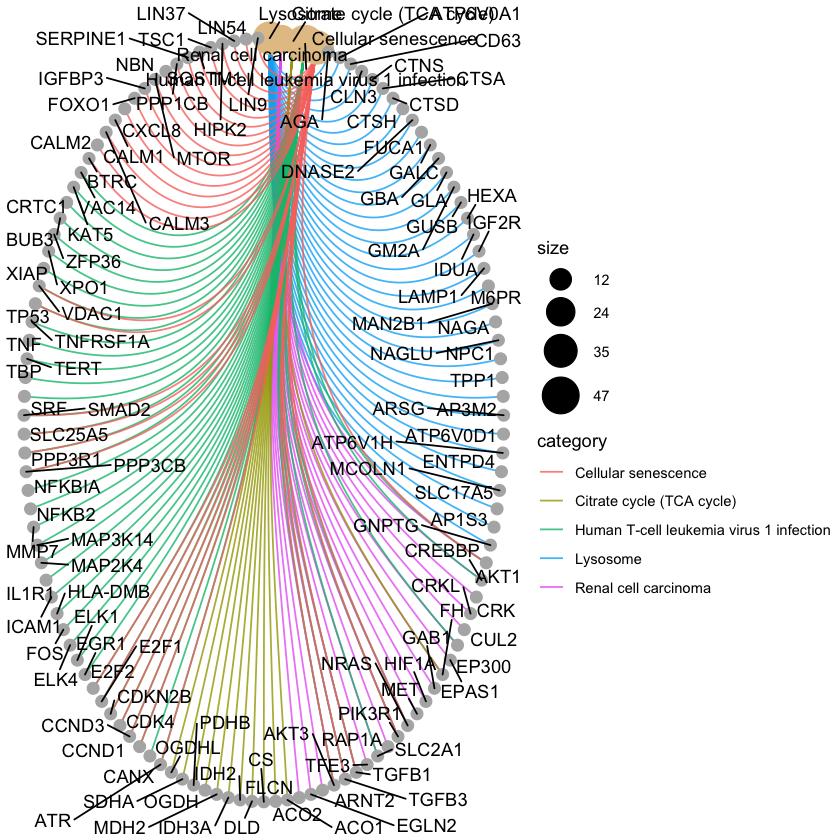

In [6]:
resKEGGEntrez <- setReadable(resKEGG, 'org.Hs.eg.db', 'ENTREZID')
p1 <- cnetplot(resKEGGEntrez, node_label="all") #foldChangeを色で反映させることができない
plot(p1)
p2 <- cnetplot(resKEGGEntrez, circular = TRUE, colorEdge = TRUE)
plot(p2)

### 2-3-4. enrichment map

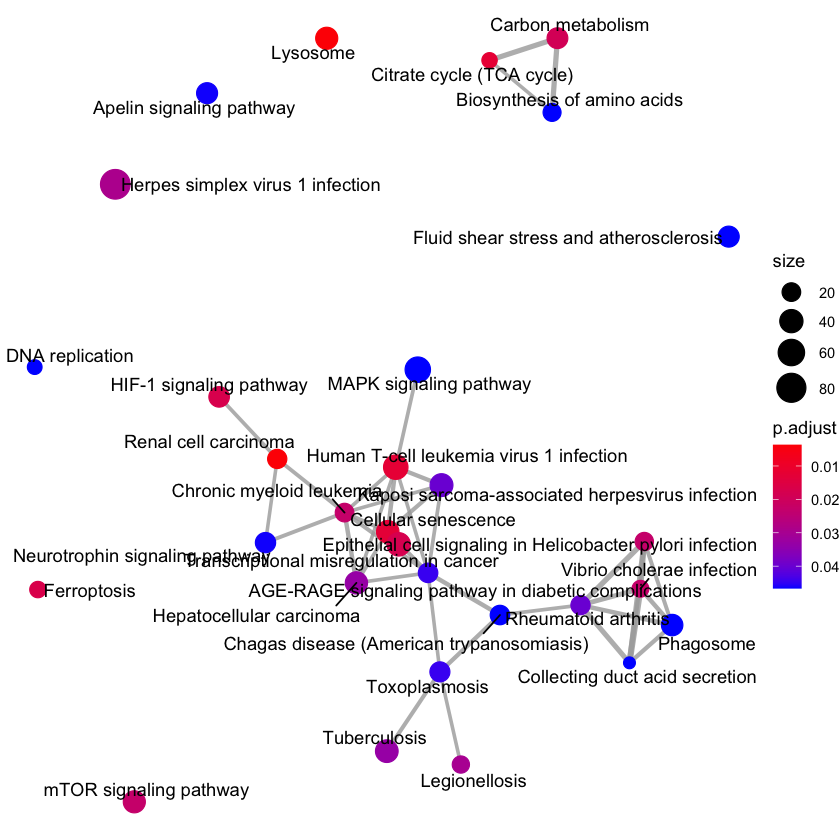

In [7]:
p3 <- emapplot(resKEGGEntrez)
plot(p3)